# Composition Axon Projection

In this example, we show how neurons can be connected by using detailed axonal reconstructions disjunct from their soma. In essence, axonal reconstructions are placed in the volume similar to how ordinary neurons are placed, and then connected using touch detection. This is useful when connecting different regions together, especially for somatotopically organized projection patterns. 

To define a new projection, the following should be defined in a .json-file:
 - a mapping between points in the source and target regions (intermediate values are interpolated),
 - a list of morphologies to use, and optionally,
 - the rotation of the termination zone.

### Minimal Example of a Configuration File
For example, the file may look like this:


```
{
    "ExampleProjection" : {
        "projection" : {
            "source" : [[4850, -150, -150],
                        [4850, -150, 150],
                        [4850, 150, -150],
                        [4850, 150, 150],
                        [5150, -150, -150],
                        [5150, -150, 150],
                        [5150, 150, -150],
                        [5150, 150, 150]],
            
            "destination" : [[-5150, -150, -150],
                             [-5150, -150, 150],
                             [-5150, 150, -150],
                             [-5150, 150, 150],
                             [-4850, -150, -150],
                             [-4850, -150, 150],
                             [-4850, 150, -150],
                             [-4850, 150, 150]]
    },

     "morphologies" : ["$SNUDDA_DATA/InputAxons/GPe2Striatum/prototypical-axon.swc"],
     
     "rotation" : {
            "rotation": [[1, 0, 0, 0, 1, 0, 0, 0, 1],
                        [1, 0, 0, 0, 1, 0, 0, 0, 1],
                        [1, 0, 0, 0, 1, 0, 0, 0, 1],
                        [1, 0, 0, 0, 1, 0, 0, 0, 1],
                        [1, 0, 0, 0, 1, 0, 0, 0, 1],
                        [1, 0, 0, 0, 1, 0, 0, 0, 1],
                        [1, 0, 0, 0, 1, 0, 0, 0, 1],
                        [1, 0, 0, 0, 1, 0, 0, 0, 1]]}
    }

}
```
Here, a neuron at ```[4850, -150, -150]``` will project to a neuron at ```[-5150, -150, -150]```.

Once the location of the termination zone is calculated, an axonal reconstruction is chosen randomly from 'morphologies'. The morphology is then rotated based on the rotation supplied. 


### Configuration File Using Paths
If the number of points used in the mapping is large, alternatively, a path can be specified:

```
{
    "ExampleProjection" : {
        "projection" : {
            "projection_file" : "$SNUDDA_DATA/InputAxons/GPe2Striatum/projection_map.json",
    },

     "morphologies" : ["$SNUDDA_DATA/InputAxons/GPe2Striatum/prototypical-axon.swc"],
     
     "rotation" : {
            "rotation_file": "$SNUDDA_DATA/InputAxons/GPe2Striatum/rotation_map.json"
    }

}
```

This functions similarily to the previous example. The projection map should look like the following:

```
{
    "source" : [...],
    "destination" : [...]
}
```

The rotation map: 
```
{
    "position": [...],
    "rotation": [...]
}
```

Optionally, a 'mapping' parameter can be supplied to rotation. If set to 'source', the rotation is decided based on the position of the source rather than the termination zone. 



## Define volumes
Here we use ```create_cube_mesh``` to create two cubical volumes with sides 300 micrometer that are 10 mm apart.

In [1]:
import os
from snudda.place import create_cube_mesh

network_path = os.path.join("networks", "composite_axon_example")
mesh_file_a = os.path.join(network_path, "mesh", "volume_A.obj")
mesh_file_b = os.path.join(network_path, "mesh", "volume_B.obj")

create_cube_mesh(mesh_file_a, [5e-3,0,0], 300e-6, "Volume A - connect structures example")
create_cube_mesh(mesh_file_b, [-5e-3,0,0], 300e-6, "Volume B - connect structures example")

duration = 1.0

## Building the network
Below, we build a small network consisting of two separate volumes (using ```define_structure```) with neurons added to them (```add_neurons```). The .json-file containing the projection configuration is supplied as an argument, ```projection_file``` to ```add_neurons```.

In [2]:
from snudda import SnuddaInit

si = SnuddaInit(network_path=network_path, random_seed=123)

si.define_structure(struct_name="VolumeA", struct_mesh=mesh_file_a, d_min=15e-6, mesh_bin_width=50e-6)
si.define_structure(struct_name="VolumeB", struct_mesh=mesh_file_b, d_min=15e-6, mesh_bin_width=50e-6)

proj_file = os.path.join("$SNUDDA_DATA", "InputAxons", "GPe2Striatum", "example-projection-config.json")

si.add_neurons(name="dSPN", num_neurons=20, volume_id="VolumeA",
               neuron_dir=os.path.join("$DATA","neurons","striatum","dspn"),
               axon_config=proj_file)
si.add_neurons(name="iSPN", num_neurons=20, volume_id="VolumeB",
               neuron_dir=os.path.join("$DATA","neurons","striatum","ispn"))

# Normally we would use add_neuron_target to connect the neurons in the same volume together, 
# but this time we want to use neuron_projection instead.

SPN2SPNdistDepPruning = "1-exp(-(0.4*d/60e-6)**2)"
pfdSPNiSPN = os.path.join("$DATA", "synapses", "striatum", "PlanertFitting-DI-tmgaba-fit.json")

si.add_neuron_target(neuron_name="dSPN",
                     target_name="iSPN",
                     region_name="VolumeA",
                     connection_type="GABA",
                     # projection_file=proj_file, # -- moved to add_neuron
                     projection_name="ExampleProjection",
                     dist_pruning=SPN2SPNdistDepPruning,
                     f1=None, soft_max=None, mu2=None, a3=None,
                     conductance=[0.24e-9, 0.1e-9],
                     parameter_file=pfdSPNiSPN,
                     mod_file="tmGabaA",
                     channel_param_dictionary={"tau1": (1.3e-3, 1e3),
                                               "tau2": (12.4e-3, 1e3),
                                               "failRate": 0.7})

si.write_json()

Adding neurons: dSPN from dir /home/hjorth/HBP/Snudda/snudda/data/neurons/striatum/dspn
Adding neurons: iSPN from dir /home/hjorth/HBP/Snudda/snudda/data/neurons/striatum/ispn
Writing networks/composite_axon_example/network-config.json


In [3]:
os.environ["IPYTHONDIR"] = os.path.join(os.path.abspath(os.getcwd()), ".ipython")
os.environ["IPYTHON_PROFILE"] = "default"
os.system("ipcluster start -n 4 --profile=$IPYTHON_PROFILE --ip=127.0.0.1 --log-level ERROR 2> parallel-log.txt &")

import time
time.sleep(10) # Wait for ipcluster to start

In [4]:
from snudda import Snudda
snd = Snudda(network_path=network_path, parallel=True, ipython_profile="default")
snd.create_network()

Placing neurons
Network path: networks/composite_axon_example
Reading IPYPARALLEL connection info from /home/hjorth/HBP/Snudda/examples/notebooks/ProjectionExample/.ipython/profile_default/security/ipcontroller-client.json

Reading SNUDDA_DATA=None from networks/composite_axon_example/network-config.json
Reading SNUDDA_DATA=/home/hjorth/HBP/Snudda/snudda/utils/../data from networks/composite_axon_example/network-synapses.hdf5
Generating 10649 points for networks/composite_axon_example/mesh/volume_A.obj
n_points = 10128, previous close_pairs = 20878
n_points = 9633, previous close_pairs = 17156
n_points = 9165, previous close_pairs = 14277
n_points = 8722, previous close_pairs = 11912
n_points = 8305, previous close_pairs = 9919
n_points = 7913, previous close_pairs = 8366
n_points = 7547, previous close_pairs = 6946
n_points = 7208, previous close_pairs = 5900
n_points = 6894, previous close_pairs = 4948
n_points = 6605, previous close_pairs = 4095
n_points = 6341, previous close_pairs

In [5]:
snd.setup_input(input_config="test-input.json")

Setting up inputs, assuming input.json exists
Reading IPYPARALLEL connection info from /home/hjorth/HBP/Snudda/examples/notebooks/ProjectionExample/.ipython/profile_default/security/ipcontroller-client.json

Reading SNUDDA_DATA=None from networks/composite_axon_example/network-config.json
Reading SNUDDA_DATA=/home/hjorth/HBP/Snudda/snudda/utils/../data from networks/composite_axon_example/network-synapses.hdf5
Writing input spikes to networks/composite_axon_example/input-spikes.hdf5
Reading SNUDDA_DATA=None from networks/composite_axon_example/network-config.json
Reading SNUDDA_DATA=/home/hjorth/HBP/Snudda/snudda/utils/../data from networks/composite_axon_example/network-synapses.hdf5
importing SnuddaInput from snudda.input.input on engine(s)
Writing spikes to networks/composite_axon_example/input-spikes.hdf5
stop_parallel disabled, to keep pool running.

Execution time: 18.7s


In [6]:
os.system("ipcluster stop")

2024-02-28 13:02:32.160 [IPClusterStop] Stopping cluster 
2024-02-28 13:02:32.160 [IPClusterStop] Stopping controller
2024-02-28 13:02:32.300 [IPClusterStop] Stopping engine(s): 1709121724


0

Reading SNUDDA_DATA=None from networks/composite_axon_example/network-config.json
Reading SNUDDA_DATA=/home/hjorth/HBP/Snudda/snudda/utils/../data from networks/composite_axon_example/network-synapses.hdf5


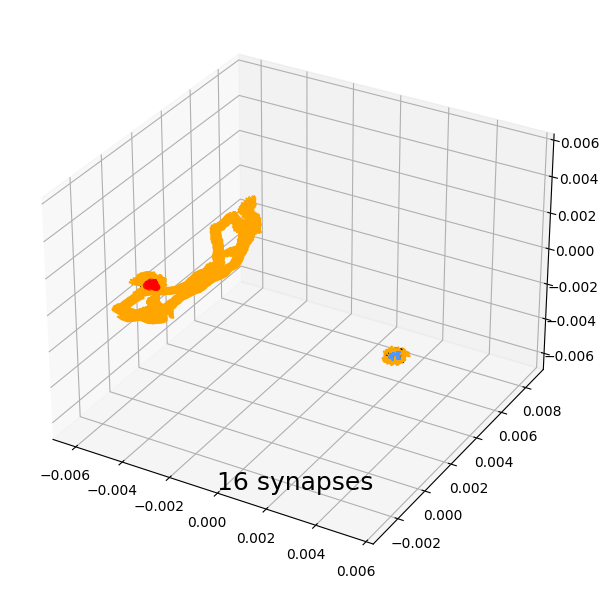

(<module 'matplotlib.pyplot' from '/home/hjorth/HBP/Snudda/venv/lib/python3.9/site-packages/matplotlib/pyplot.py'>,
 <Axes3D: >)

In [7]:
from snudda.plotting import PlotNetwork
pn = PlotNetwork(network=network_path)
pn.plot()

## Simulation (in serial)

```snd.simulate(time=duration)```

## Simulation (in parallel)

If it does not work in the notebook, try running the command from the terminal.

In [8]:
cmd = f"mpiexec -n 4 snudda simulate {network_path} --time {duration}"
print(cmd)
os.system(cmd)

mpiexec -n 4 snudda simulate networks/composite_axon_example --time 1.0
args.ipython_profile = None
args.ipython_profile = None
args.ipython_profile = None
args.ipython_profile = None
numprocs=4
args: Namespace(action='simulate', path='networks/composite_axon_example', network_file=None, input_file=None, output_file=None, time=1.0, snudda_data=None, simulation_config=None, record_volt=True, randomseed=None, neuromodulation=None, disable_synapses=None, disable_gj=None, mech_dir=None, profile=False, verbose=False, exportCoreNeuron=False, record_all=None, ipython_profile=None)
Using input file networks/composite_axon_example/input-spikes.hdf5
args: Namespace(action='simulate', path='networks/composite_axon_example', network_file=None, input_file=None, output_file=None, time=1.0, snudda_data=None, simulation_config=None, record_volt=True, randomseed=None, neuromodulation=None, disable_synapses=None, disable_gj=None, mech_dir=None, profile=False, verbose=False, exportCoreNeuron=False, recor

0

Loading networks/composite_axon_example/simulation/output.hdf5
WARNING. Depolarisation block in neuron - neuron_id: (name, parameter_key, morphology_key):
8: (iSPN_3, default, )
10: (iSPN_3, default, )
11: (iSPN_3, default, )
15: (iSPN_3, default, )
17: (iSPN_3, default, )
22: (dSPN_2, default, )
25: (dSPN_2, default, )
28: (dSPN_2, default, )
33: (dSPN_2, default, )
35: (dSPN_2, default, )
Saving figure to networks/composite_axon_example/figures/spike-raster.png


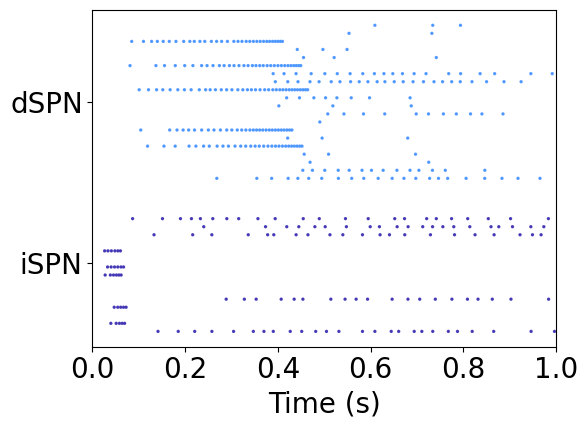

In [9]:
from snudda.plotting import SnuddaPlotSpikeRaster2
fig_file_raster = f"spike-raster.png"

time_range_zoom = (0,duration)
spr = SnuddaPlotSpikeRaster2(network_path=network_path)


spr.plot_spike_raster(fig_file=fig_file_raster, time_range=time_range_zoom)